In [1]:
import os
import glob
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **Helper Classes**

Use the Spectrogram class to create spectrograms from waveforms and get a helper function for creating spectrogram plots

In [2]:
FRAME_LENGTH = 255
FRAME_STEP = 128

class Spectrogram():

  def __init__(self):
    pass

  """
    Returns the spectrogram of the waveform.
  """
  def get_spectrogram(self, waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

  """
    Returns the plot data of the spectrogram.
  """
  def plot_spectrogram(self, spectrogram, ax):
    if (len(spectrogram.shape) > 2):
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Create an Audio Dataloader class to help with generating training, validation and test sets from audio files

In [3]:
BATCH_SIZE = 32
OUTPUT_SEQUENCE_LENGTH = 16000
TRAIN_DATASET = '/kaggle/input/audio-cats-and-dogs/cats_dogs/train'
VALIDATION_DATASET = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test'

class AudioDataLoader():

  def __init__(self):
    pass

  """
    Returns the training dataset.
  """
  def get_training_dataset_and_class_names(self):
    train_ds = tf.keras.utils.audio_dataset_from_directory(
      TRAIN_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    class_names = train_ds.class_names
    train_ds = train_ds.map(self._squeeze, tf.data.AUTOTUNE)
    return train_ds, class_names

  """
    Returns the validation and test datasets.
  """
  def get_validation_and_test_datasets(self):
    validation_ds = tf.keras.utils.audio_dataset_from_directory(
      VALIDATION_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    validation_ds = validation_ds.map(self._squeeze, tf.data.AUTOTUNE)
    validation_ds, test_ds = self._get_test_dataset(validation_ds)

    return validation_ds, test_ds

  """
    Returns the test dataset.
  """
  def _get_test_dataset(self, validation_dataset):
    validation_dataset = validation_dataset.shard(num_shards=2, index=0)
    test_dataset = validation_dataset.shard(num_shards=2, index=1)
    return validation_dataset, test_dataset

  """
    Squeezes the waveform dimension.
  """
  def _squeeze(self, waveforms, labels):
    waveforms = tf.squeeze(waveforms, axis=-1)
    return waveforms, labels

### **Load Audio Datasets**

In [4]:
dataloader = AudioDataLoader()
train_ds, class_names = dataloader.get_training_dataset_and_class_names()
validation_ds, test_ds = dataloader.get_validation_and_test_datasets()

Found 210 files belonging to 2 classes.
Found 67 files belonging to 2 classes.


### **Validate the Audio Dataset**

Verify the classnames and plot the waveforms

In [5]:
print(class_names)

['cat', 'dog']


In [6]:
for waveforms, labels in train_ds.take(1):
  print(waveforms.shape)
  print(labels.shape)

(32, 16000)
(32,)


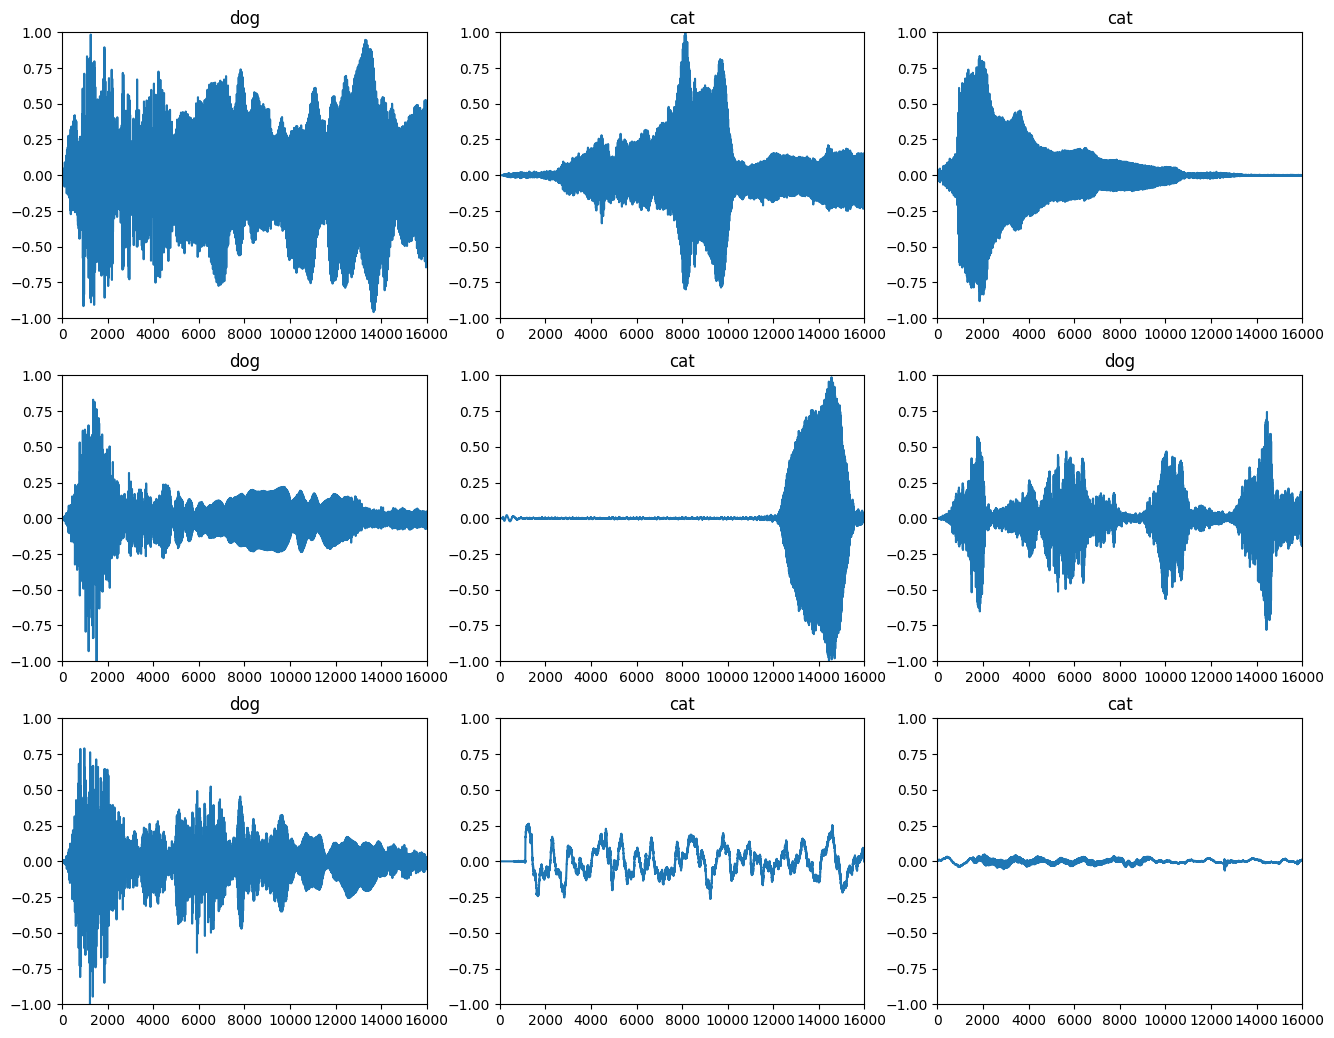

In [7]:
plt.figure(figsize=(16,9))
plt.subplots_adjust(bottom=-0.2)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.plot(waveforms[i].numpy())
  plt.title(class_names[labels[i]])
  plt.axis([0, 16000, -1, 1])

### **Generate Spectrograms from the Waveforms**

In [8]:
spec = Spectrogram()

In [9]:
for j in range(6):
  label = class_names[labels[j]]
  waveform = waveforms[j]
  spectrogram = spec.get_spectrogram(waveform)
  print(f"\nLabel: {label}")
  print(f"Spectrogram Shape: {spectrogram.shape}\n")

  display.display(display.Audio(waveform, rate=16000))


Label: dog
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: dog
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: dog
Spectrogram Shape: (124, 129, 1)



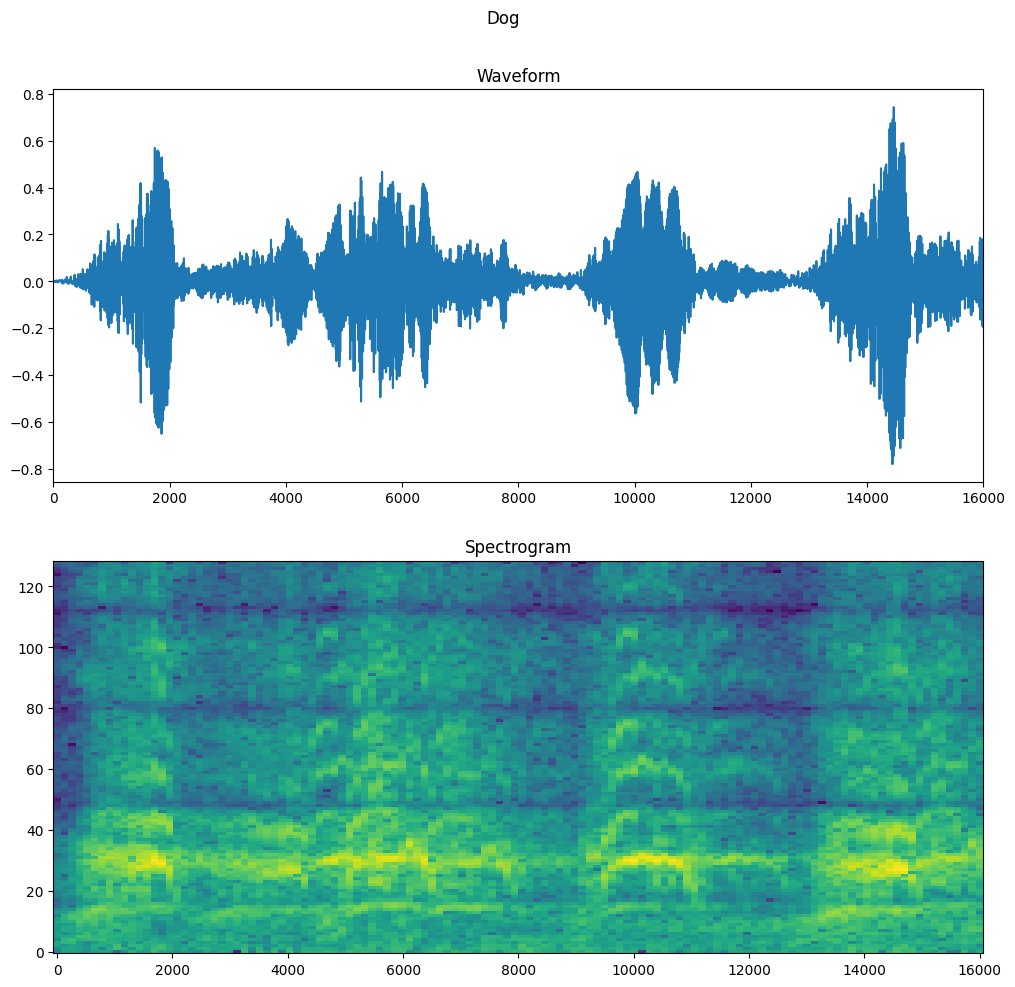

In [10]:
fig, axes = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(bottom=-0.2)

timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

spec.plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

### **Generate Spectrogram Datasets to be used in the CNN**

In [11]:
train_spectrogram_ds = train_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

validation_spectrogram_ds = validation_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_spectrogram_ds = test_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [12]:
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
  break

Plot some of the spectrograms to verify they look right

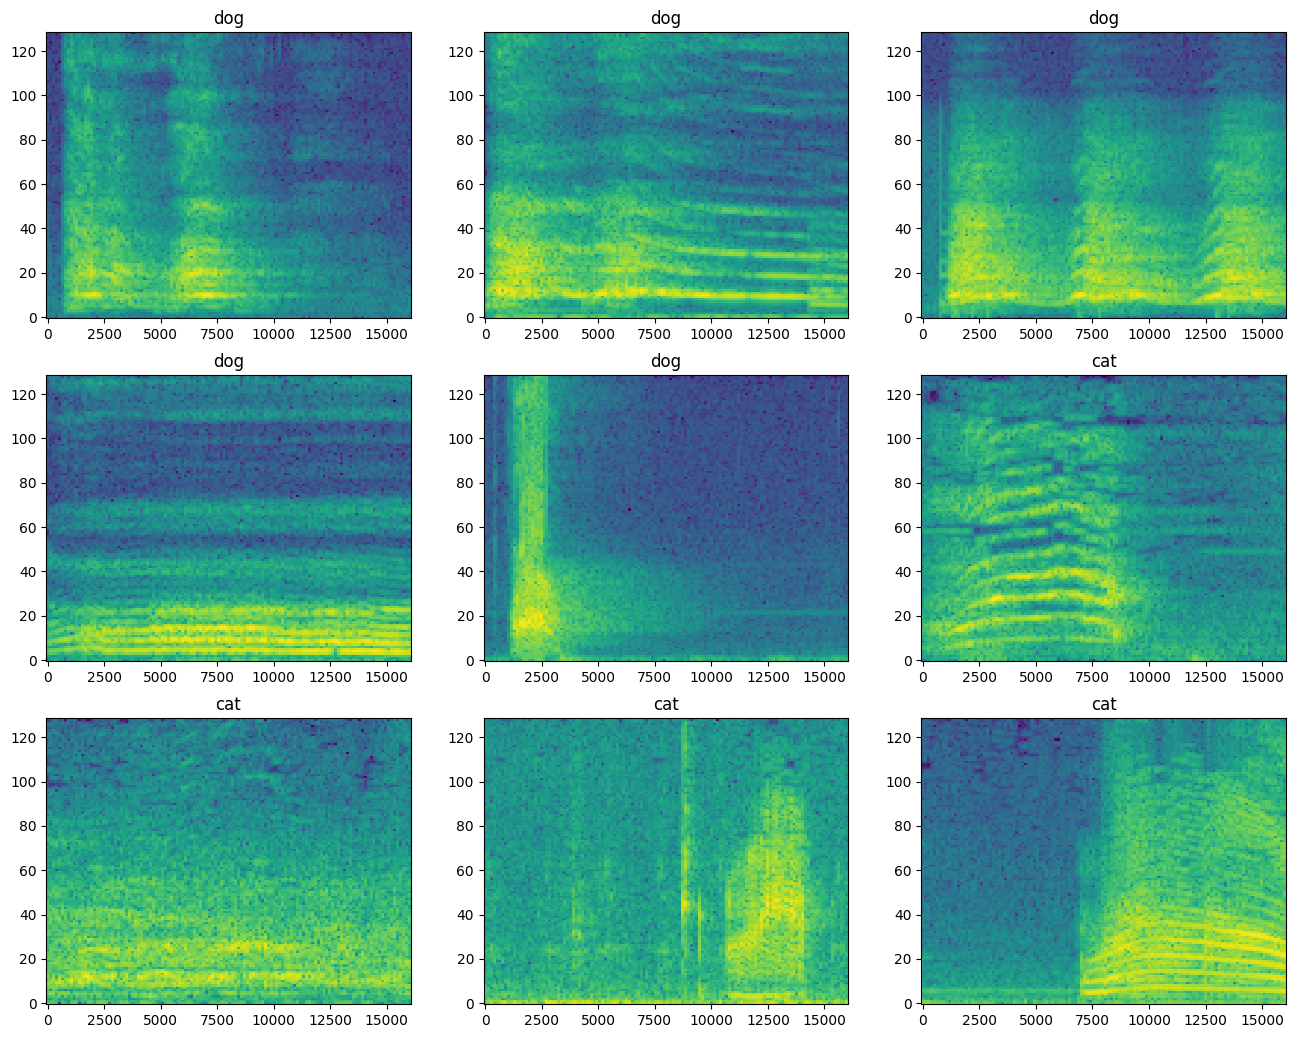

In [13]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(bottom=-0.2)

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spec.plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(class_names[example_labels[i].numpy()])

plt.show()

In [14]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_spectrogram_ds = validation_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### **Create the CNN Model**

In [15]:
input_shape = example_spectrograms.shape[1:]
print(input_shape)

num_labels = len(class_names)

normalization = tf.keras.layers.Normalization()

# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
normalization.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Resizing(32, 32),
    normalization,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels)
])

model.summary()

(124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=validation_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/10


2024-04-11 14:32:49.456018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 5s 115ms/step - loss: 0.5036 - accuracy: 0.7524 - val_loss: 0.4527 - val_accuracy: 0.8286
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 0.3728 - accuracy: 0.8810 - val_loss: 0.4097 - val_accuracy: 0.8000
Epoch 3/10
7/7 [==============================] - 0s 7ms/step - loss: 0.3021 - accuracy: 0.8762 - val_loss: 0.4350 - val_accuracy: 0.8571
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2452 - accuracy: 0.9143 - val_loss: 0.4343 - val_accuracy: 0.8571
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1731 - accuracy: 0.9381 - val_loss: 0.4269 - val_accuracy: 0.8571
Epoch 6/10
7/7 [==============================] - 0s 8ms/step - loss: 0.1808 - accuracy: 0.9429 - val_loss: 0.4722 - val_accuracy: 0.8857
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1635 - accuracy: 0.9429 - val_loss: 0.5008 - val_accuracy: 0.8571
Epoch 8/10
7/7 [===========================

### **Classification Report**

Text(0.5, 0, 'Epoch')

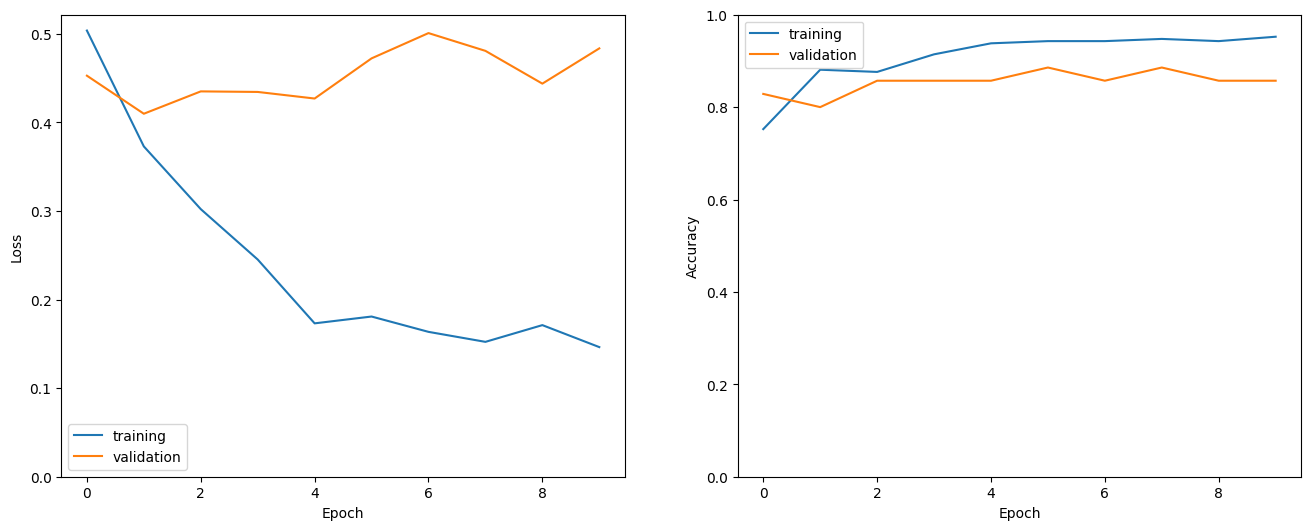

In [18]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [19]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 158ms/step - loss: 0.0014 - accuracy: 1.0000


{'loss': 0.0013608139706775546, 'accuracy': 1.0}

In [20]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 102ms/step


In [21]:
y_pred = tf.argmax(y_pred, axis=1)

In [22]:
y_true = tf.concat([y for x, y in test_spectrogram_ds], axis=0)

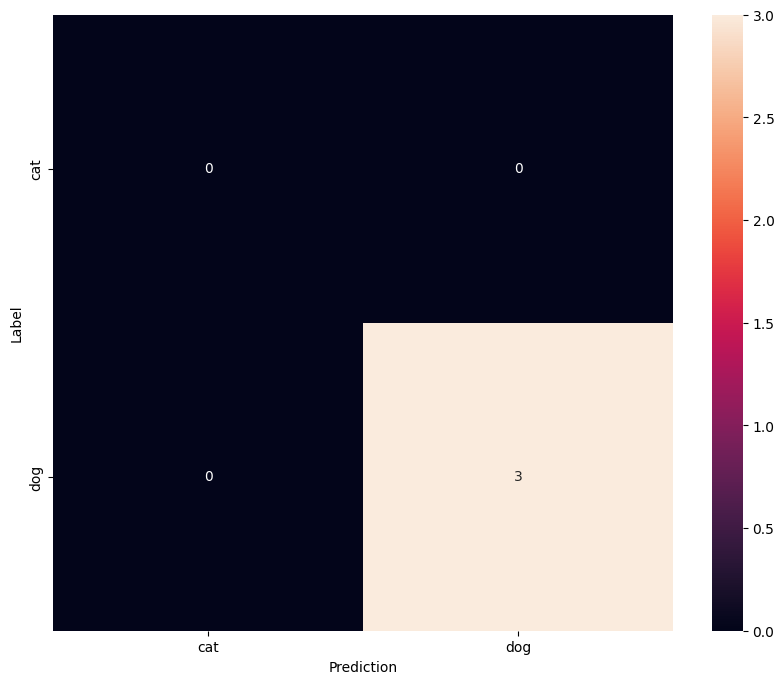

In [23]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### **Test the Model on a Completely New Audio File**

Using a cat meow wav file downloaded from FreeSound.com to test the model

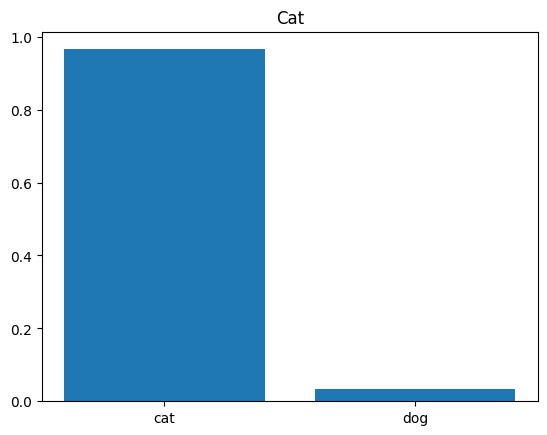

In [24]:
x = '/kaggle/input/cat-meow/cat_test_2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['cat', 'dog']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Cat')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [26]:
model.save("audio_classification_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
loaded_model = tf.keras.models.load_model("audio_classification_model.h5")
x = tf.io.read_file("/kaggle/input/audio-cats-and-dogs/cats_dogs/test/test/dog_barking_112.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)

# Get the spectrogram
x_spec = spec.get_spectrogram(x)
x_spec = x_spec[tf.newaxis, ...]

# Make prediction using the loaded model
prediction = loaded_model(x_spec)

# Get the predicted label
predicted_label_index = tf.argmax(prediction, axis=1).numpy()[0]
predicted_label = class_names[predicted_label_index]

print("Predicted Label:", predicted_label)


Predicted Label: dog
